In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

brewery_2022_interpolated = pd.read_csv("Data/brewery_production_2022_interpolated.csv")
brewery_2017_2019 = pd.read_csv("Data/brewery_production_2017_2019.csv")
wa_breweries_with_ratings = pd.read_csv("Data/wa_breweries_with_ratings.csv")
wa_breweries_with_ratings = wa_breweries_with_ratings[["brewery", "rating", "total_visits", "unique_visits", "leg_district"]]
wa_breweries_with_ratings['customer_loyalty'] = wa_breweries_with_ratings['total_visits'] / wa_breweries_with_ratings['unique_visits']

In [2]:
brewery_2022_interpolated.columns

Index(['brewery', 'brewery_type', 'address', 'city', 'zipcode', 'county',
       'latitude', 'longitude', 'year_established', 'guild_member',
       'closed_since_2022', 'untappd_profile_link', 'January', 'February',
       'March', 'April', 'May', 'June', 'July', 'August', 'September',
       'October', 'November', 'December', 'total_annual'],
      dtype='object')

In [3]:
brewery_2022_interpolated["closed_since_2022"].value_counts()

closed_since_2022
0    356
1     32
Name: count, dtype: int64

In [4]:
brewery_2022_total = pd.DataFrame({
    "brewery_name": brewery_2022_interpolated["brewery"], 
    "annual_production": brewery_2022_interpolated["total_annual"],
    "year": 2022,
    "estimate": 1
})


In [5]:
brewery_2017_2022 = pd.concat([brewery_2022_total, brewery_2017_2019])

In [6]:
def num_handler(s):
    if s == "DNP" or s == "Do Not Publish":
        return np.nan
    if type(s) == str:
        s = s.replace(",", "")
    return float(s)

In [7]:
brewery_2017_2022

,brewery_name,annual_production,year,estimate
0,192 Brewing Company,NaN,2022.0,1.0
1,20 Corners Brewing Company,1481.65,2022.0,1.0
2,23rd Ave Brewery,NaN,2022.0,1.0
3,4 Stitch Brewing Company,NaN,2022.0,1.0
4,45 Degree Brewhouse,87.07,2022.0,1.0
...,...,...,...,...
1224,Willapa Brewing Co,155,2017.0,1.0
1225,Wingman Brewers,876,2017.0,1.0
1226,Yakima Craft Brewing Company,"1,500",2017.0,0.0
1227,Yakima Valley Hops,5,2017.0,1.0


In [8]:
brewery_production_trend = pd.DataFrame(brewery_2017_2022.groupby("brewery_name")["annual_production"].agg(lambda x: np.nan if len(x) == 1 else np.polyfit(np.arange(len(x)), np.array(list(map(lambda v: num_handler(v) ,x.values[::-1]))), 1)[0] / num_handler(x.iloc[-1])))
brewery_production_trend.rename(columns={"annual_production": "production_trend"}, inplace=True)
brewery_production_trend.fillna(0, inplace=True)
brewery_production_size = pd.DataFrame(brewery_2017_2022.groupby("brewery_name")["annual_production"].agg(lambda x: np.sum(list(map(lambda v: num_handler(v) ,x.values)))/len(x)))
# categorize brewery production by percentile
brewery_production_size.fillna(0, inplace=True)
brewery_production_size.rename(columns={"annual_production": "production_size"}, inplace=True)
brewery_production_stat = pd.concat([brewery_production_trend, brewery_production_size], axis=1)

In [9]:
rawDF = pd.merge(brewery_2022_interpolated, brewery_production_stat, left_on="brewery", right_on="brewery_name", how="inner")
rawDF = pd.merge(rawDF, wa_breweries_with_ratings, left_on="brewery", right_on="brewery", how="inner")

In [10]:
rawDF[rawDF['closed_since_2022'] == 1]

,brewery,brewery_type,address,city,zipcode,county,latitude,longitude,year_established,guild_member,...,November,December,total_annual,production_trend,production_size,rating,total_visits,unique_visits,leg_district,customer_loyalty
6,5 North Brewing Company,taproom,6501 N Cedar Rd,Spokane,99208,Spokane,47.717587,-117.432850,2020,0,...,16.04,14.83,267.32,0.182832,246.6600,3.63,770.0,256.0,3,3.007812
39,Barlow's Brewery,brewpub,705 SE Park Crest Ave Suite D430,Vancouver,98683,Clark,45.616262,-122.522206,2020,0,...,NaN,NaN,NaN,0.000000,0.0000,3.78,3305.0,1458.0,17,2.266804
48,Berchmans Brewing Company,nano,25 North Front Street,Yakima,98901,Yakima,46.602834,-120.507761,2014,0,...,1.00,NaN,NaN,0.000000,0.0000,3.55,1334.0,474.0,15,2.814346
77,Camas Brewing Company,taproom,335 NE Cedar St,Camas,98607,Clark,45.585423,-122.403814,2021,0,...,9.58,9.58,144.37,0.000000,144.3700,3.57,377.0,219.0,17,1.721461
89,Common Language Brewing Company,micro,"926 W Sprague Ave, Spokane, WA",Spokane,99201,Spokane,47.657515,-117.426234,2022,0,...,13.00,4.50,229.00,0.000000,229.0000,3.82,962.0,351.0,3,2.740741
90,Counterbalance Brewing Company,micro,503 S Michigan St Ste B,Seattle,98108,King,47.545389,-122.330586,2015,0,...,13.58,13.58,357.83,-0.135973,588.2075,3.72,26687.0,10555.0,34,2.528375
98,Cursed Brewing,taproom,3108 S Lloyd Ln,Spokane,99223,Spokane,47.625965,-117.343766,2022,1,...,4.78,-3.06,6.50,0.000000,6.5000,4.25,798.0,164.0,9,4.865854
99,Darach Brewing Company,taproom,1015 N State St,Bellingham,98225,Whatcom,48.745707,-122.481381,2022,0,...,0.00,5.50,5.50,0.000000,5.5000,NaN,NaN,NaN,42,NaN
100,Decibel Brewing Company,micro,18204 Bothell Everett Hwy Suite C,Bothell,98012,Snohomish,47.833256,-122.210337,2016,0,...,NaN,4.52,NaN,0.000000,0.0000,3.62,5021.0,1386.0,1,3.622655
123,E2W Brewing,micro,12913 Shady Glen Ave SE,Olalla,98359,Kitsap,47.432463,-122.594069,2020,0,...,NaN,NaN,NaN,0.000000,0.0000,3.69,459.0,256.0,26,1.792969


In [11]:
dataDF = rawDF[["brewery", 'brewery_type', 'city', 'county', 'latitude', 'longitude', 'leg_district',
       'year_established', 'guild_member',
       'closed_since_2022', "total_annual", "production_trend", "production_size", "rating", "customer_loyalty", "total_visits"]]
dataDF['total_annual'] = dataDF['total_annual'].fillna(0)
dataDF['year_established'] = dataDF['year_established'].apply(lambda x: 2022 - x + 1)
dataDF['average_visits'] = dataDF['total_visits'] / dataDF['year_established']
dataDF['leg_district'] = dataDF["leg_district"].astype("category")

C:\Users\david.chen\AppData\Local\Temp\ipykernel_6488\1929857491.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataDF['total_annual'] = dataDF['total_annual'].fillna(0)
C:\Users\david.chen\AppData\Local\Temp\ipykernel_6488\1929857491.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataDF['year_established'] = dataDF['year_established'].apply(lambda x: 2022 - x + 1)
C:\Users\david.chen\AppData\Local\Temp\ipykernel_6488\1929857491.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [12]:
dataDF = pd.get_dummies(dataDF[['latitude', 'longitude', 'brewery_type', 'city', 'county',
       'year_established', 'guild_member',
       'closed_since_2022', "production_trend", "production_size", "rating", "customer_loyalty", "average_visits"]])
dataDF.dropna(inplace=True)

In [13]:
dataDF.shape

(423, 199)

In [14]:
# find the neighbors' production sizes
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(dataDF[["longitude", "latitude"]])
distances, indices = neigh.kneighbors(dataDF[["longitude", "latitude"]])

# get the production size of neighbors
neighbor_production_size_mean = []
neighbor_production_size_max = []
neighbor_production_size_min = []
neighbor_production_size_std = []
for i in range(len(indices)):
    neighbor_production_size_mean.append(dataDF.iloc[indices[i][1:]]["production_size"].mean())
    neighbor_production_size_max.append(dataDF.iloc[indices[i][1:]]["production_size"].max())
    neighbor_production_size_min.append(dataDF.iloc[indices[i][1:]]["production_size"].min())
    neighbor_production_size_std.append(dataDF.iloc[indices[i][1:]]["production_size"].std())

dataDF["neighbor_production_size_mean"] = neighbor_production_size_mean
dataDF["neighbor_production_size_max"] = neighbor_production_size_max
dataDF["neighbor_production_size_min"] = neighbor_production_size_min
dataDF["neighbor_production_size_std"] = neighbor_production_size_std

In [15]:
# stats for breweries closed since 2022
dataDF.groupby("closed_since_2022").mean()

,latitude,longitude,year_established,guild_member,production_trend,production_size,rating,customer_loyalty,average_visits,brewery_type_Micro,...,county_Thurston,county_Wahkiakum,county_Walla Walla,county_Whatcom,county_Whitman,county_Yakima,neighbor_production_size_mean,neighbor_production_size_max,neighbor_production_size_min,neighbor_production_size_std
closed_since_2022,,,,,,,,,,,,,,,,,,,,,
0,47.430574,-121.545891,10.482234,0.487310,1.387283,2064.624630,3.733858,3.142763,3852.935266,0.002538,...,0.020305,0.002538,0.017766,0.048223,0.010152,0.025381,2097.344209,4762.715292,452.666527,2136.305475
1,47.382850,-121.026763,7.689655,0.068966,0.057885,642.034397,3.717241,2.788320,1557.857249,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.034483,2572.092550,7706.388276,191.376322,3712.849808


In [16]:
dataDF["closed_since_2022"].value_counts()

closed_since_2022
0    394
1     29
Name: count, dtype: int64

In [17]:
dataDF.shape

(423, 203)

In [18]:
X = pd.get_dummies(dataDF.drop(columns=["closed_since_2022", "longitude", "latitude"])).values
y = dataDF["closed_since_2022"].values

In [19]:
from sklearn.model_selection import train_test_split
import sklearn.model_selection as skm
from sklearn.metrics import roc_auc_score

seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=int(np.sqrt(X.shape[1])))
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from ISLP import confusion_table

# kfold grid search with skm
# fit a support vector classifier on the training set
svm = SVC()

kfold = skm.KFold(3, 
                  random_state=seed,
                  shuffle=True)
grid = skm.GridSearchCV(svm,
                        {'C':[0.01,0.1,1,5,10, 100], "gamma": [0.01,0.1,1,5,10,100], "kernel":['linear', 'rbf'], "class_weight":['balanced', None]},
                        refit=True,
                        cv=kfold,
                        scoring='precision')
grid.fit(X_train, y_train)
print("grid best params:", grid.best_params_)

best_ = grid.best_estimator_

# train error rate with best model
y_train_hat = best_.predict(X_train)
print("best estimator train error:", 1 - accuracy_score(y_train, y_train_hat))
print("best estimator train auc:", roc_auc_score(y_train, y_train_hat))

# test error rate with best model
y_test_hat = best_.predict(X_test)
print("best estimator test error:", 1 - accuracy_score(y_test, y_test_hat))
print("best estimator test auc:", roc_auc_score(y_test, y_test_hat))

print(confusion_table(y_train_hat, y_train))
print(confusion_table(y_test_hat, y_test))

c:\Users\david.chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\david.chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\david.chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

grid best params: {'C': 1, 'class_weight': 'balanced', 'gamma': 1, 'kernel': 'rbf'}
best estimator train error: 0.0
best estimator train auc: 1.0
best estimator test error: 0.046511627906976716
best estimator test auc: 0.6666666666666666
Truth        0   1
Predicted         
0          354   0
1            0  26
Truth       0  1
Predicted       
0          40  2
1           0  1


c:\Users\david.chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\david.chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\david.chen\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [20]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(best_, X_train, y_train, n_repeats=30, random_state=seed)
best_features_idx = np.arange(X.shape[1])[perm_importance.importances_mean.argsort()][-2:]

In [21]:
from matplotlib import font_manager
import matplotlib as mpl
# set theme

# use lato font
font_path = 'Reference/Lato/Lato-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# set colors
col_yellow = '#ffa400'
col_green = '#256143'
col_brown = '#9c5421'
col_off_black = '#434343'
mpl.rcParams['text.color'] = col_off_black # title and legend
mpl.rcParams['xtick.color'] = col_off_black # tick marks
mpl.rcParams['ytick.color'] = col_off_black # tick marks
mpl.rcParams['axes.labelcolor'] = col_off_black # axes labels

# set font sizes
mpl.rcParams['axes.titlesize'] = 14 # title
mpl.rcParams['axes.labelsize'] = 12 # axes labels
mpl.rcParams['xtick.labelsize'] = 11 # tick marks
mpl.rcParams['ytick.labelsize'] = 11 # tick marks
mpl.rcParams['legend.title_fontsize'] = 12 # legend title
mpl.rcParams['legend.fontsize'] = 11 # legend text

# figure sizes (horizontal/vertical/square)
figsize_v = (6,10)
figsize_h = (10,6)

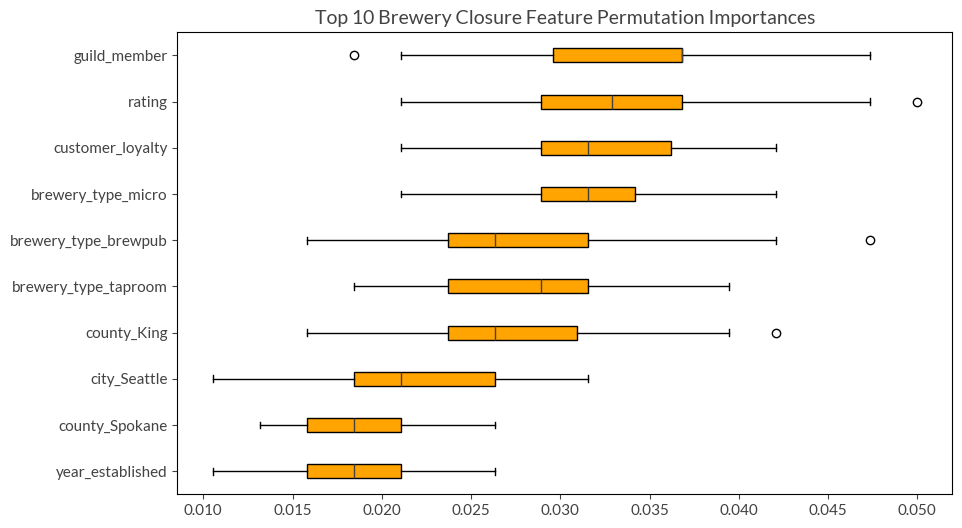

In [22]:
feature_names = dataDF.drop(columns=["closed_since_2022", "longitude", "latitude"]).columns
sorted_idx = perm_importance.importances_mean.argsort()

# plot feature importance in box plots using the given theme
fig, ax = plt.subplots(figsize=figsize_h)
ax.boxplot(perm_importance.importances[sorted_idx[-10:]].T, vert=False, labels=feature_names[sorted_idx[-10:]], patch_artist=True, medianprops=dict(color=col_off_black), boxprops=dict(facecolor=col_yellow), widths=0.3)
ax.set_title("Top 10 Brewery Closure Feature Permutation Importances")
plt.show()

In [23]:
fig.savefig("Viz/model_closure_svm.png")